In [2]:
import sys
import os
sys.path.append(os.path.abspath('../..')) # include top level package in python path

In [3]:
import torch
from comparison.examples.vae_mnist import VAE_MNIST
from comparison.loss import ELBO, IWAE
from tqdm.notebook import tqdm

In [36]:
# Change device as needed. 
# CPU is supported on all machines, CUDA for specific GPUs.

device = 'cpu'
#device = 'cuda'

In [43]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_dataset = datasets.MNIST('./_mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))

test_dataset = datasets.MNIST('./_mnist', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [44]:
def train(model, optim, dataloader, no_epochs=3):
    model.train()
    
    train_loss = []
    iwae_loss = []
    for epoch in range(1, no_epochs + 1):
        for imgs, _ in tqdm(dataloader, desc="Training Epoch №%s" % epoch, leave=False):
            imgs = imgs.view(-1, 28*28).to(device)
            vae_res = model(imgs, K=1)
            loss = -IWAE(vae_res)
            train_loss.append(loss.item())

            optim.zero_grad()
            loss.backward()
            optim.step()
            
            
            vae_res = model(imgs, K=64)
            loss = -IWAE(vae_res)
            iwae_loss.append(loss.item())

    return torch.Tensor(train_loss), torch.Tensor(iwae_loss)

In [45]:
model = VAE_MNIST().to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model.parameters)

<bound method Module.parameters of VAE_MNIST(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc21): Linear(in_features=400, out_features=20, bias=True)
  (fc22): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)>


In [46]:
losses, iwae_losses = train(model, optim, train_loader, 5)

Training Epoch №1:   0%|          | 0/469 [00:00<?, ?it/s]

Training Epoch №2:   0%|          | 0/469 [00:00<?, ?it/s]

Training Epoch №3:   0%|          | 0/469 [00:00<?, ?it/s]

Training Epoch №4:   0%|          | 0/469 [00:00<?, ?it/s]

Training Epoch №5:   0%|          | 0/469 [00:00<?, ?it/s]

In [47]:
import matplotlib.pyplot as plt

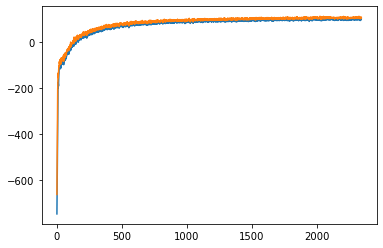

In [48]:
plt.plot(-losses)
plt.plot(-iwae_losses)

In [50]:
losses

tensor([ 746.0529,  676.0829,  614.0941,  ..., -102.6563,  -96.7296,
        -100.2261])

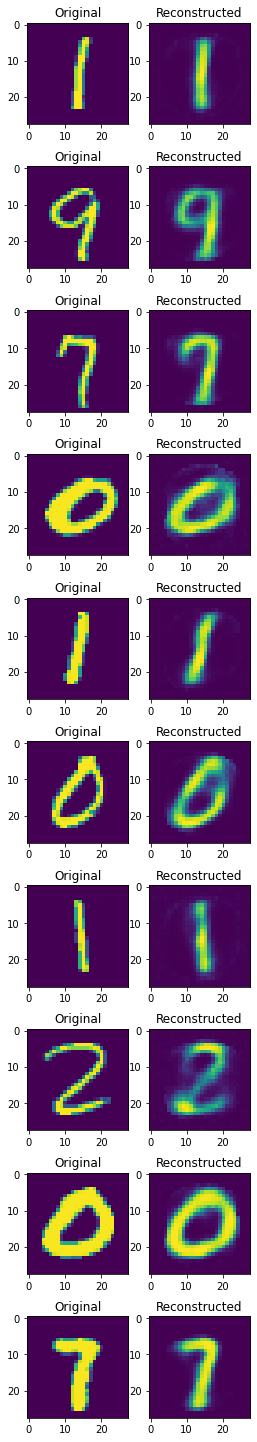

In [15]:
make plt.figure(figsize=(4,26))

for imgs, _ in test_loader:
    for i in range(imgs.shape[0]):
        if i >= 10:
            break
        img = imgs[i].view(28 * 28).to(device)
        recon = model.reconstruct(img)
        ax = plt.subplot(10, 2, 2 * i + 1)
        ax.imshow(img.view(28, 28).clone().detach().cpu())
        plt.title("Original")
        ax = plt.subplot(10, 2, 2 * i + 2)
        ax.imshow(recon.view(28, 28).clone().detach().cpu())
        plt.title("Reconstructed")
        
plt.show()